<a href="https://colab.research.google.com/github/javahedi/SemanticFilter/blob/main/nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
import torch
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sentence_transformers import SentenceTransformer
import numpy as np

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# Load NLP resources
nlp = spacy.load("en_core_web_sm")


In [ ]:
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Load sentence transformer models with device specification
models = [
    SentenceTransformer("all-MiniLM-L6-v2", device=device),
    #SentenceTransformer("all-mpnet-base-v2", device=device),
    #SentenceTransformer("multi-qa-mpnet-base-cos-v1", device=device)
]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Download stop words and set up stemmer
stemmer = PorterStemmer()
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Define query terms
virology_keywords     = ["virus", "virology", "viral", "infection", "pathogen"]
epidemiology_keywords = ["epidemiology", "outbreak", "spread", "public health", "disease"]
query_terms           = virology_keywords + epidemiology_keywords


In [ ]:

# Define functions
def load_data(file_path, columns=['Title', 'Abstract']):
    """Loads data from a CSV file."""
    return pd.read_csv(file_path, usecols=columns, encoding='utf-8')

def fill_na(data, columns=['Title', 'Abstract']):
    """Fills NaN values in specified columns with empty strings."""
    for col in columns:
        data[col] = data[col].fillna(" ")
    return data

def merge_columns(data, new_column='text', columns_to_merge=['Title', 'Abstract']):
    """Merges specified columns into a single text column."""
    data[new_column] = data[columns_to_merge[0]] + ". " + data[columns_to_merge[1]]
    return data

def remove_special_characters(text):
    return re.sub(r'[^.a-z\s]', '', text.lower())

def tokenize_and_remove_stopwords(text, stop_words):
    tokens = text.split()
    return [word for word in tokens if word not in stop_words]

def apply_stemming(tokens, stemmer):
    return [stemmer.stem(word) for word in tokens]

def apply_lemmatization(tokens, nlp):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

def preprocess_text(text, nlp, stemmer, stop_words):
    text = remove_special_characters(text)
    tokens = tokenize_and_remove_stopwords(text, stop_words)
    tokens = apply_stemming(tokens, stemmer)
    lemmatized = apply_lemmatization(tokens, nlp)
    return " ".join(lemmatized)

def calculate_similarity(model, query, text):
    query_embedding = model.encode(query, device=device)
    text_embeddings = model.encode(text, device=device)
    similarity      = model.similarity(query_embedding, text_embeddings)
    return similarity.detach().cpu().numpy() if hasattr(similarity, 'detach') else np.array(similarity)


def meets_threshold(similarity_matrix, percentage_elements, percentage_max_value):
    max_value = np.max(similarity_matrix)
    threshold = (percentage_max_value / 100) * max_value
    count_above_threshold = np.sum(similarity_matrix >= threshold)
    required_count = (percentage_elements / 100) * similarity_matrix.size
    return count_above_threshold >= required_count

def polishing(texts):
    """Cleans up and splits text into sentences."""
    texts = re.findall(r'[^.]+\. ?', texts)
    texts = [text.strip() for text in texts]
    texts = [' '.join([word for word in text.split() if len(word) > 1]) for text in texts]
    return [text for text in texts if text != ""]


def filter_text(text, models, query, percentage_elements=5, percentage_max_value=70):
    sentences = polishing(text)

    # If there's only one model, compute similarity and return the result directly
    if len(models) == 1:
        similarity_matrix = calculate_similarity(models[0], query, sentences)
        return meets_threshold(similarity_matrix, percentage_elements, percentage_max_value)

    # If there are multiple models, calculate similarity for each and count how many exceed the threshold
    results = [
        meets_threshold(calculate_similarity(model, query, sentences), percentage_elements, percentage_max_value)
        for model in models
    ]

    # Return True if at least two models exceed the threshold
    return results.count(True) >= 2




In [ ]:
def main(file_path):
    # Load and prepare data
    data = load_data(file_path)
    data = fill_na(data)
    data = merge_columns(data)

    # Preprocess text
    data['processed_text'] = data['text'].apply(lambda x: preprocess_text(x, nlp, stemmer, stop_words) if isinstance(x, str) else "")

    # Preprocess query terms
    processed_query = [preprocess_text(term, nlp, stemmer, stop_words) for term in query_terms]

    # Filter text based on similarity with the query
    data['filtered'] = data['processed_text'].apply(lambda x: filter_text(x, models, query=processed_query))

    return data

In [ ]:
# Example usage
file_path = "https://raw.githubusercontent.com/jd-coderepos/virology-ai-papers/main/collection_with_abstracts.csv"
%time processed_data = main(file_path)


CPU times: user 59min 54s, sys: 13.6 s, total: 1h 8s
Wall time: 1h 13s


In [ ]:
processed_data.head(3)

,Title,Abstract,text,processed_text,filtered
0,Editorial: The operationalization of cognitive...,,Editorial: The operationalization of cognitive...,editori operation cognit system comprehen visu...,True
1,Characterization of arteriosclerosis based on ...,PURPOSE: Our purpose is to develop a computer ...,Characterization of arteriosclerosis based on ...,character arteriosclerosi base computeraid mea...,True
2,Multi-scale input layers and dense decoder agg...,Accurate segmentation of COVID-19 lesions from...,Multi-scale input layers and dense decoder agg...,multiscal input layer den decod aggreg network...,True


In [ ]:
def plot(data, column, figsize=(7, 3), palette="viridis"):

    method_counts = data[column].value_counts()

    # Plot
    plt.figure(figsize=figsize)
    sns.barplot(x=method_counts.index,
                y=method_counts.values,
                dodge=False, palette=palette)
    plt.ylabel("Number of Abstracts")
    plt.title("Number of Abstracts by Category")
    plt.show()

In [ ]:
plot(plot,'filtered')

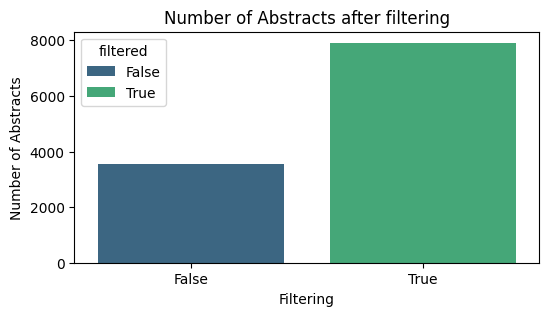

In [ ]:
# Count the number of abstracts in each cluster
filter_counts = processed_data['filtered'].value_counts()

# Plot
plt.figure(figsize=(6, 3))
sns.barplot(x=filter_counts.index,
            y=filter_counts.values,
            hue=filter_counts.index,
            dodge=False, palette="viridis")
plt.xlabel("Filtering")
plt.ylabel("Number of Abstracts")
plt.title("Number of Abstracts after filtering")
plt.show()

In [ ]:
# Save the processed data as a CSV file
processed_data.to_csv('processed_data.csv', index=False)

# Classification
  For the papers deemed relevant, classify them according to the type of method used: ["text mining", "computer vision", "both", "other"].

In [ ]:
# Define keywords for each category
query_text_mining = [
  "natural language processing",
	"text mining",
	"nlp",
	"computational linguistics",
	"language processing",
	"text data analytics",
	"textual data",
	"speech and language technology",
	"language modeling",
	"computational semantics",
    "long short term memory network",
    "grnn",
    "rnn",
    "lstm",
    "large language model",
    'llm',
]
query_computer_vision = [
    "computer vision",
    "image processing",
    "object recognition",
    "scene understanding",
    "vision model",
    "convolutional neural network",
    "cnn",
    "feedforward",
    "recurrent",
    "generative artificial intelligence",
	  "ai",
	  "deep learning",
    "transformer",
	  "self attention",
    "sequence to sequence",

]

In [ ]:
def calculate_avg_similarity(text, model, query_text_mining, query_computer_vision):

    # Calculate similarity for both query sets
    similarity_text_mining     = calculate_similarity(model, query_text_mining, text)
    similarity_computer_vision = calculate_similarity(model, query_computer_vision, text)

    # Calculate average similarity
    avg_similarity_text_mining     = np.mean(similarity_text_mining)
    avg_similarity_computer_vision = np.mean(similarity_computer_vision)

    return avg_similarity_text_mining, avg_similarity_computer_vision



def add_similarity_columns(data, model, query_text_mining, query_computer_vision):
    data[['avg_similarity_text_mining', 'avg_similarity_computer_vision']] = \
        data['processed_text'].apply(lambda x: pd.Series(calculate_avg_similarity(x, model, query_text_mining, query_computer_vision)))
    return data


In [ ]:
  processed_query_text_mining     =   [preprocess_text(term, nlp, stemmer, stop_words) for term in query_text_mining]
  processed_query_computer_vision =   [preprocess_text(term, nlp, stemmer, stop_words) for term in query_computer_vision]

In [ ]:
# Filter text based on similarity with the query
%time output = add_similarity_columns(processed_data[processed_data['filtered'] == True],models[0], processed_query_text_mining,processed_query_computer_vision)

CPU times: user 43min 14s, sys: 7.93 s, total: 43min 22s
Wall time: 43min 37s


<ipython-input-14-5658cac0493b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['avg_similarity_text_mining', 'avg_similarity_computer_vision']] = \
<ipython-input-14-5658cac0493b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['avg_similarity_text_mining', 'avg_similarity_computer_vision']] = \


In [ ]:
output.head(3)

,Title,Abstract,text,processed_text,filtered,avg_similarity_text_mining,avg_similarity_computer_vision
0,Editorial: The operationalization of cognitive...,,Editorial: The operationalization of cognitive...,editori operation cognit system comprehen visu...,True,0.184691,0.219440
1,Characterization of arteriosclerosis based on ...,PURPOSE: Our purpose is to develop a computer ...,Characterization of arteriosclerosis based on ...,character arteriosclerosi base computeraid mea...,True,0.088057,0.105917
2,Multi-scale input layers and dense decoder agg...,Accurate segmentation of COVID-19 lesions from...,Multi-scale input layers and dense decoder agg...,multiscal input layer den decod aggreg network...,True,0.162234,0.215172


In [ ]:
# Calculate basic descriptive statistics
statistics_summary = output[['avg_similarity_text_mining', 'avg_similarity_computer_vision']].describe()
print(statistics_summary)

       avg_similarity_text_mining  avg_similarity_computer_vision
count                 7914.000000                     7914.000000
mean                     0.104507                        0.094714
std                      0.053548                        0.048370
min                     -0.065200                       -0.049947
25%                      0.065657                        0.060635
50%                      0.106234                        0.095518
75%                      0.140574                        0.128102
max                      0.321504                        0.268960


In [ ]:
# Calculate additional metrics
correlation = output['avg_similarity_text_mining'].corr(output['avg_similarity_computer_vision'])
print(f"Correlation between Text Mining and Computer Vision similarity: {correlation}")

Correlation between Text Mining and Computer Vision similarity: 0.7601235198316934


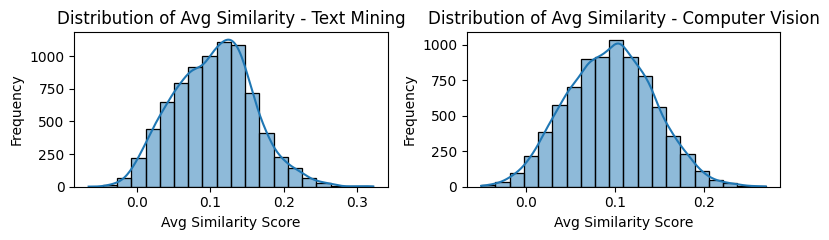

In [ ]:
# Plot histograms for each similarity measure
plt.figure(figsize=(8, 2.5))

# Histogram for Text Mining similarity
plt.subplot(1, 2, 1)
sns.histplot(output['avg_similarity_text_mining'], bins=20, kde=True)
plt.title('Distribution of Avg Similarity - Text Mining')
plt.xlabel('Avg Similarity Score')
plt.ylabel('Frequency')

# Histogram for Computer Vision similarity
plt.subplot(1, 2, 2)
sns.histplot(output['avg_similarity_computer_vision'], bins=20, kde=True)
plt.title('Distribution of Avg Similarity - Computer Vision')
plt.xlabel('Avg Similarity Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

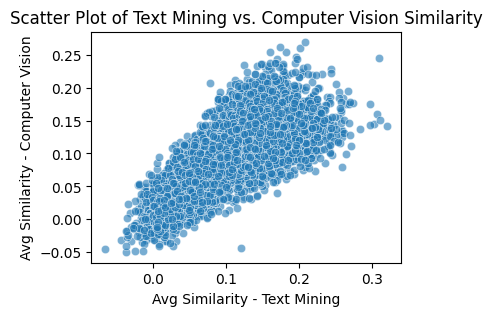

In [ ]:

# Scatter plot to show correlation
plt.figure(figsize=(4, 3))
sns.scatterplot(x='avg_similarity_text_mining', y='avg_similarity_computer_vision', data=output, alpha=0.6)
plt.title('Scatter Plot of Text Mining vs. Computer Vision Similarity')
plt.xlabel('Avg Similarity - Text Mining')
plt.ylabel('Avg Similarity - Computer Vision')
plt.show()


In [ ]:
def assign_method_labels(data):
    # Criteria thresholds
    text_mining_75th = 0.14
    computer_vision_75th = 0.13
    both_50th = 0.10
    tolerance = 0.02
    text_mining_25th = 0.066
    computer_vision_25th = 0.061

    labels = []
    for _, row in data.iterrows():
        text_mining_sim = row['avg_similarity_text_mining']
        computer_vision_sim = row['avg_similarity_computer_vision']

        # Assign 'text mining' if it meets threshold and is greater than computer vision
        if text_mining_sim > text_mining_75th and text_mining_sim > computer_vision_sim:
            labels.append('text mining')

        # Assign 'computer vision' if it meets threshold and is greater than text mining
        elif computer_vision_sim > computer_vision_75th and computer_vision_sim > text_mining_sim:
            labels.append('computer vision')

        # Assign 'both' if both scores meet the "both" threshold and are close in similarity
        elif (
            text_mining_sim > both_50th and computer_vision_sim > both_50th and
            abs(text_mining_sim - computer_vision_sim) < tolerance
        ):
            labels.append('both')

        # Assign 'other' if both scores are below their respective lower thresholds
        elif text_mining_sim < text_mining_25th and computer_vision_sim < computer_vision_25th:
            labels.append('other')

        # Fallback: Assign based on the highest similarity score if none of the criteria match
        else:
            if text_mining_sim > computer_vision_sim:
                labels.append('text mining')
            else:
                labels.append('computer vision')

    data['method'] = labels
    return data

# Apply the function
output = assign_method_labels(output)


<ipython-input-22-3aa6ff1ca0d3>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['method'] = labels


In [ ]:
output.head(3)

,Title,Abstract,text,processed_text,filtered,avg_similarity_text_mining,avg_similarity_computer_vision,method
0,Editorial: The operationalization of cognitive...,,Editorial: The operationalization of cognitive...,editori operation cognit system comprehen visu...,True,0.184691,0.219440,computer vision
1,Characterization of arteriosclerosis based on ...,PURPOSE: Our purpose is to develop a computer ...,Characterization of arteriosclerosis based on ...,character arteriosclerosi base computeraid mea...,True,0.088057,0.105917,computer vision
2,Multi-scale input layers and dense decoder agg...,Accurate segmentation of COVID-19 lesions from...,Multi-scale input layers and dense decoder agg...,multiscal input layer den decod aggreg network...,True,0.162234,0.215172,computer vision


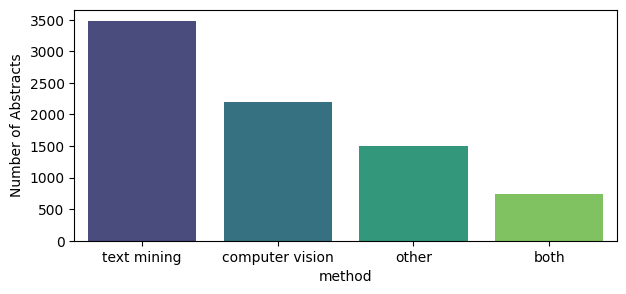

In [ ]:
# Count the number of abstracts in each cluster
method_counts = output['method'].value_counts()

# Plot
plt.figure(figsize=(7, 3))
sns.barplot(x=method_counts.index,
            y=method_counts.values,
            hue=method_counts.index,
            dodge=False, palette="viridis")
#plt.xlabel("Filtering")
plt.ylabel("Number of Abstracts")
#plt.title("Number of Abstracts after filtering")
plt.show()

In [ ]:
def assign_method_labels_from_distribution(data):
    # Define mean and std thresholds based on distribution
    text_mining_mean     = data['avg_similarity_text_mining'].mean()
    text_mining_std      = data['avg_similarity_text_mining'].std()
    computer_vision_mean = data['avg_similarity_computer_vision'].mean()
    computer_vision_std  = data['avg_similarity_computer_vision'].std()

    labels = []
    for _, row in data.iterrows():
        text_mining_sim     = row['avg_similarity_text_mining']
        computer_vision_sim = row['avg_similarity_computer_vision']

        # Criteria for "text mining"
        if text_mining_sim > text_mining_mean + text_mining_std and text_mining_sim > computer_vision_sim:
            labels.append('text mining')

        # Criteria for "computer vision"
        elif computer_vision_sim > computer_vision_mean + computer_vision_std and computer_vision_sim > text_mining_sim:
            labels.append('computer vision')

        # Criteria for "both"
        elif (
            text_mining_mean - text_mining_std <= text_mining_sim <= text_mining_mean + text_mining_std and
            computer_vision_mean - computer_vision_std <= computer_vision_sim <= computer_vision_mean + computer_vision_std
        ):
            labels.append('both')

        # Criteria for "other"
        elif text_mining_sim < 0 and computer_vision_sim < 0:
            labels.append('other')

        # Assign to the method with the highest similarity score as a fallback
        else:
            if text_mining_sim > computer_vision_sim:
                labels.append('text mining')
            else:
                labels.append('computer vision')

    data['method2'] = labels
    return data

# Apply the function
processed_data = assign_method_labels_from_distribution(output)


<ipython-input-25-66239f3319e7>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['method2'] = labels


In [ ]:
output.head(3)

,Title,Abstract,text,processed_text,filtered,avg_similarity_text_mining,avg_similarity_computer_vision,method,method2
0,Editorial: The operationalization of cognitive...,,Editorial: The operationalization of cognitive...,editori operation cognit system comprehen visu...,True,0.184691,0.219440,computer vision,computer vision
1,Characterization of arteriosclerosis based on ...,PURPOSE: Our purpose is to develop a computer ...,Characterization of arteriosclerosis based on ...,character arteriosclerosi base computeraid mea...,True,0.088057,0.105917,computer vision,both
2,Multi-scale input layers and dense decoder agg...,Accurate segmentation of COVID-19 lesions from...,Multi-scale input layers and dense decoder agg...,multiscal input layer den decod aggreg network...,True,0.162234,0.215172,computer vision,computer vision


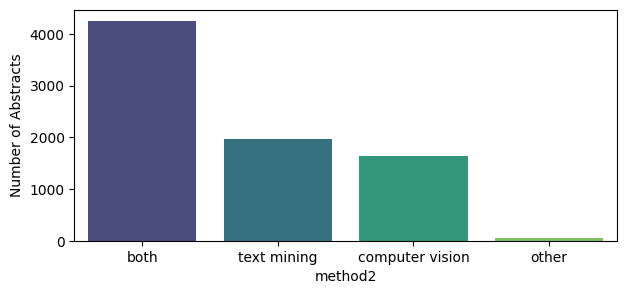

In [ ]:
# Count the number of abstracts in each cluster
method_counts = output['method2'].value_counts()

# Plot
plt.figure(figsize=(7, 3))
sns.barplot(x=method_counts.index,
            y=method_counts.values,
            hue=method_counts.index,
            dodge=False, palette="viridis")
#plt.xlabel("Filtering")
plt.ylabel("Number of Abstracts")
#plt.title("Number of Abstracts after filtering")
plt.show()

In [ ]:
def apply_kmeans_clustering(data, n_clusters=4):
    # Extract the features (average similarities)
    X = data[['avg_similarity_text_mining', 'avg_similarity_computer_vision']].values

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['cluster'] = kmeans.fit_predict(X)

    return data, kmeans

In [ ]:
output, kmeans_model = apply_kmeans_clustering(output)


In [ ]:
output.head(3)

,Title,Abstract,text,processed_text,filtered,avg_similarity_text_mining,avg_similarity_computer_vision,method,method2,cluster
0,Editorial: The operationalization of cognitive...,,Editorial: The operationalization of cognitive...,editori operation cognit system comprehen visu...,True,0.184691,0.219440,computer vision,computer vision,0
1,Characterization of arteriosclerosis based on ...,PURPOSE: Our purpose is to develop a computer ...,Characterization of arteriosclerosis based on ...,character arteriosclerosi base computeraid mea...,True,0.088057,0.105917,computer vision,both,1
2,Multi-scale input layers and dense decoder agg...,Accurate segmentation of COVID-19 lesions from...,Multi-scale input layers and dense decoder agg...,multiscal input layer den decod aggreg network...,True,0.162234,0.215172,computer vision,computer vision,0


In [ ]:

def assign_labels_to_clusters(data):
    # we have 4 clusters (text mining, computer vision, both, and other)

    # Calculate centroids
    centroids = data.groupby('cluster')[['avg_similarity_text_mining', 'avg_similarity_computer_vision']].mean()

    # Cluster interpretation based on centroid values
    cluster_labels = []
    for idx, row in data.iterrows():
        cluster_id = row['cluster']
        if centroids.loc[cluster_id, 'avg_similarity_text_mining'] > centroids.loc[cluster_id, 'avg_similarity_computer_vision']:
            cluster_labels.append('text mining')
        elif centroids.loc[cluster_id, 'avg_similarity_computer_vision'] > centroids.loc[cluster_id, 'avg_similarity_text_mining']:
            cluster_labels.append('computer vision')
        else:
            cluster_labels.append('both')

    data['method(K-means)'] = cluster_labels
    return data

In [ ]:
output = assign_labels_to_clusters(output)

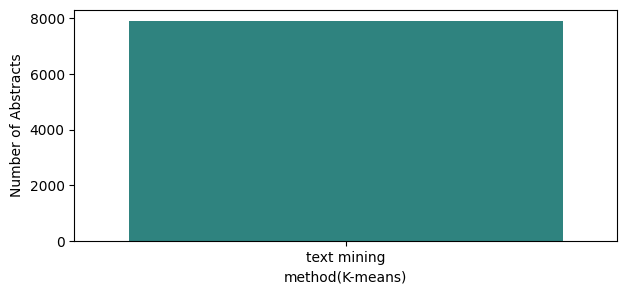

In [ ]:
# Count the number of abstracts in each cluster
method_counts = output['method(K-means)'].value_counts()

# Plot
plt.figure(figsize=(7, 3))
sns.barplot(x=method_counts.index,
            y=method_counts.values,
            hue=method_counts.index,
            dodge=False, palette="viridis")
#plt.xlabel("Filtering")
plt.ylabel("Number of Abstracts")
#plt.title("Number of Abstracts after filtering")
plt.show()